In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Importação dos dados
* uid: 000001
* horario: 14:00 a 17:30
* potencia: ativa da fase A (Kw)
* data: de 2019-02-18 (segunda semana de aula) até 2019-06-12 (data atual)
* Granularidade: 1h (potência agregada pela média)

In [2]:
raw = pd.read_csv ('../datasets/temperatura_e_potencia2.csv', sep=',')
raw.describe()

,pa,temp_celsius,pressao
count,2535.000000,2736.000000,2736.000000
mean,62.663325,22.523026,1015.396930
std,65.612594,2.867108,4.376655
min,0.000000,14.000000,1003.000000
25%,23.684701,21.000000,1012.600000
50%,30.450012,22.000000,1015.200000
75%,92.816160,24.000000,1018.000000
max,1881.630715,34.000000,1028.100000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0130226390>,
      dtype=object)

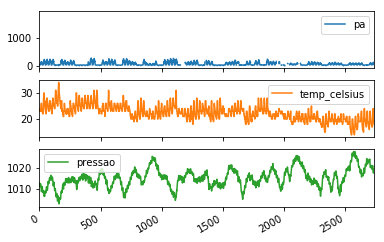

In [3]:
raw.plot(subplots=True)

# Data cleaning
* remover linhas incompletas (sistema fora do ar)
* remover oulier (falhas na coleta de dados). Acima de 500 e abaixo de 10
* remover dias não-letivos
* remover dias com falhas na medição (sistema fora do ar)
* No final sobraram 243 linhas, o que corresponde à medições ao longo de 60 dias

In [4]:
processed = raw.dropna()
processed = processed.set_index(pd.to_datetime (processed['momento'])).drop('momento', axis=1)

In [5]:
processed = processed[processed['pa']<500]

In [6]:
processed = processed[processed['pa']>10]

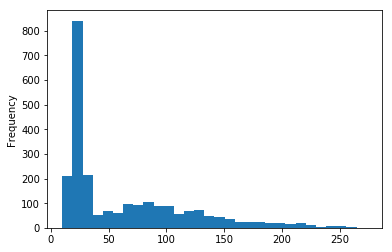

In [7]:
processed['pa'].plot.hist(bins=30)

In [8]:
#* Remove fins de semana
#create an index of just the date portion of your index (this is the slow step)
dfDays = pd.to_datetime(processed.index.date)

#create a range of business days over that period
dfBdays = pd.bdate_range(start=processed.index[0].date(), end=processed.index[-1].date())

#Filter the series to just those days contained in the business day range.
filtered = processed[dfDays.isin(dfBdays)]

In [9]:
## Removendo dias não-letivos ou com erros
# março 4,5,6
# abril 8, 15, 16,17,18,19, 22, 25, 29
# maio 1, 9, 10, 14, 15, 16, 17
# junho 20, 21
filtered = filtered[~((filtered.index.month == 3) & (filtered.index.day == 4))]
filtered = filtered[~((filtered.index.month == 3) & (filtered.index.day == 5))]
filtered = filtered[~((filtered.index.month == 3) & (filtered.index.day == 6))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 8))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 4))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 15))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 16))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 17))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 18))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 19))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 22))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 25))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 29))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 1))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 9))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 10))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 14))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 15))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 16))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 17))]
filtered = filtered[~((filtered.index.month == 6) & (filtered.index.day == 20))]
filtered = filtered[~((filtered.index.month == 6) & (filtered.index.day == 21))]

In [10]:
filtered = filtered.between_time('14:00:00', '17:00:00')

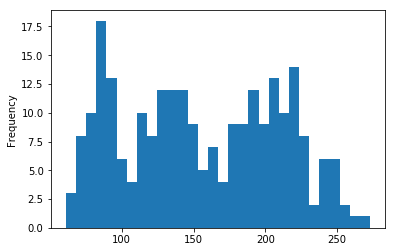

In [11]:
filtered['pa'].plot.hist(bins=30)

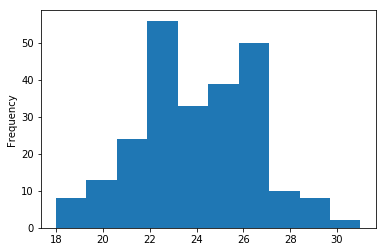

In [12]:
filtered['temp_celsius'].plot.hist(bins=10)

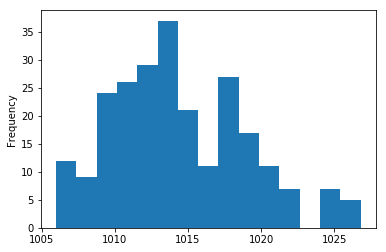

In [13]:
filtered['pressao'].plot.hist(bins=15)

Text(0, 0.5, 'Potência ativa')

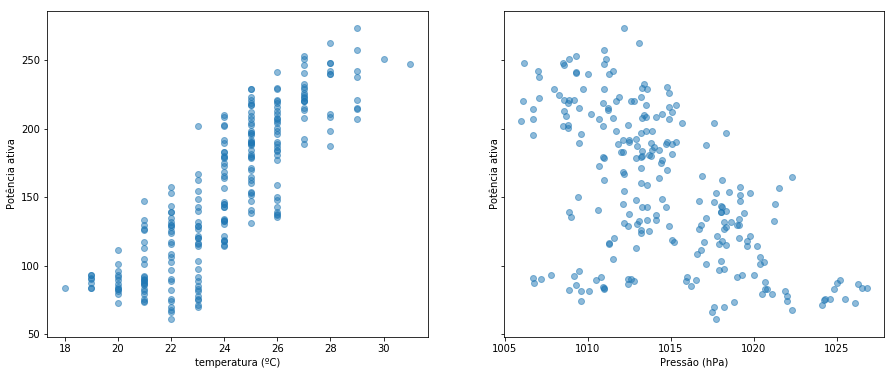

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,6))
ax1.scatter(filtered['temp_celsius'], filtered['pa'], Alpha=0.5)
ax1.set_xlabel("temperatura (ºC)")
ax1.set_ylabel("Potência ativa")
ax2.scatter(filtered['pressao'], filtered['pa'], Alpha=0.5)
ax2.set_xlabel("Pressão (hPa)")
ax2.set_ylabel("Potência ativa")

# Model Training

In [15]:
from sklearn.model_selection import train_test_split 
X = filtered.drop('pa', axis=1)
y = filtered ['pa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 

In [16]:
lm = LinearRegression()
lm.fit (X_train, y_train)
pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])

,Coefficient
temp_celsius,16.333932
pressao,-2.410938


# Model Evaluation

MAE: 20.598540251067295
RMSE: 25.113178300038


Text(0, 0.5, 'Valores previstos')

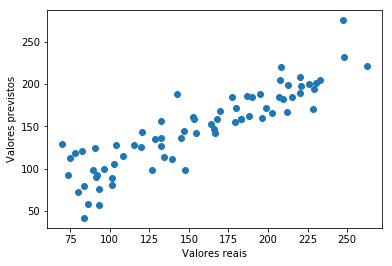

In [19]:
from sklearn import metrics
predictions = lm.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

plt.scatter(y_test,predictions)
plt.xlabel("Valores reais")
plt.ylabel("Valores previstos")

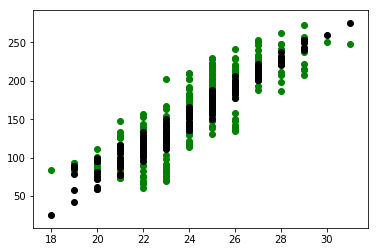

In [25]:
plt.scatter(X['temp_celsius'], y,color='g')
plt.scatter(X['temp_celsius'], lm.predict(X),color='k')

plt.show()